# Download the data

In [11]:
# %%bash

# mkdir data
# curl -L http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# mkdir write

mkdir: data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7443k  100 7443k    0     0  4363k      0  0:00:01  0:00:01 --:--:-- 6416k


In [12]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# Set running parameters

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
RESULTS_FILE = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [4]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... writing an h5ad cache file to speedup reading next time


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

# Take a look at the raw data

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


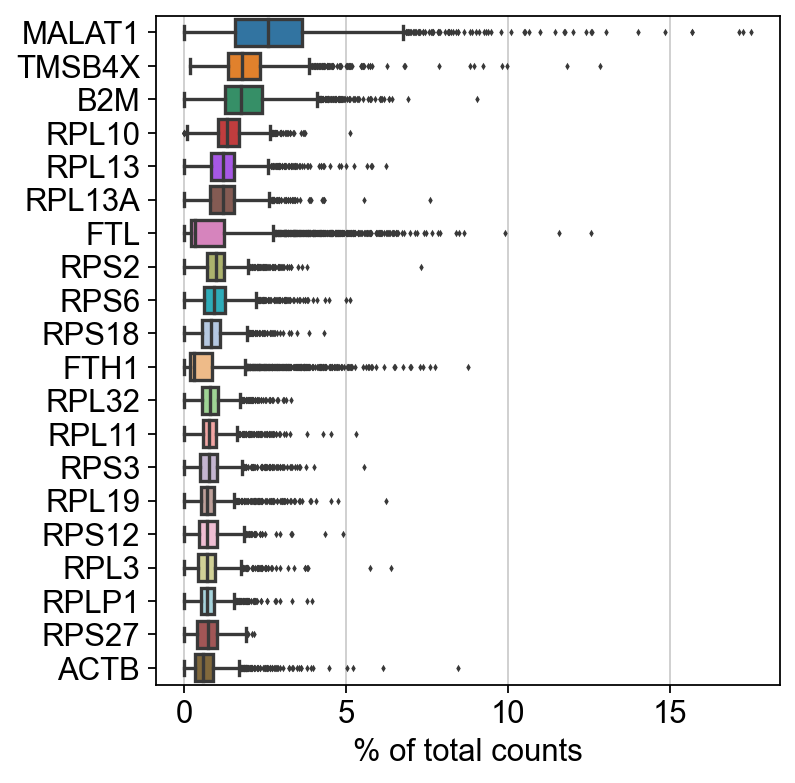

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [22]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


# Quality control

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

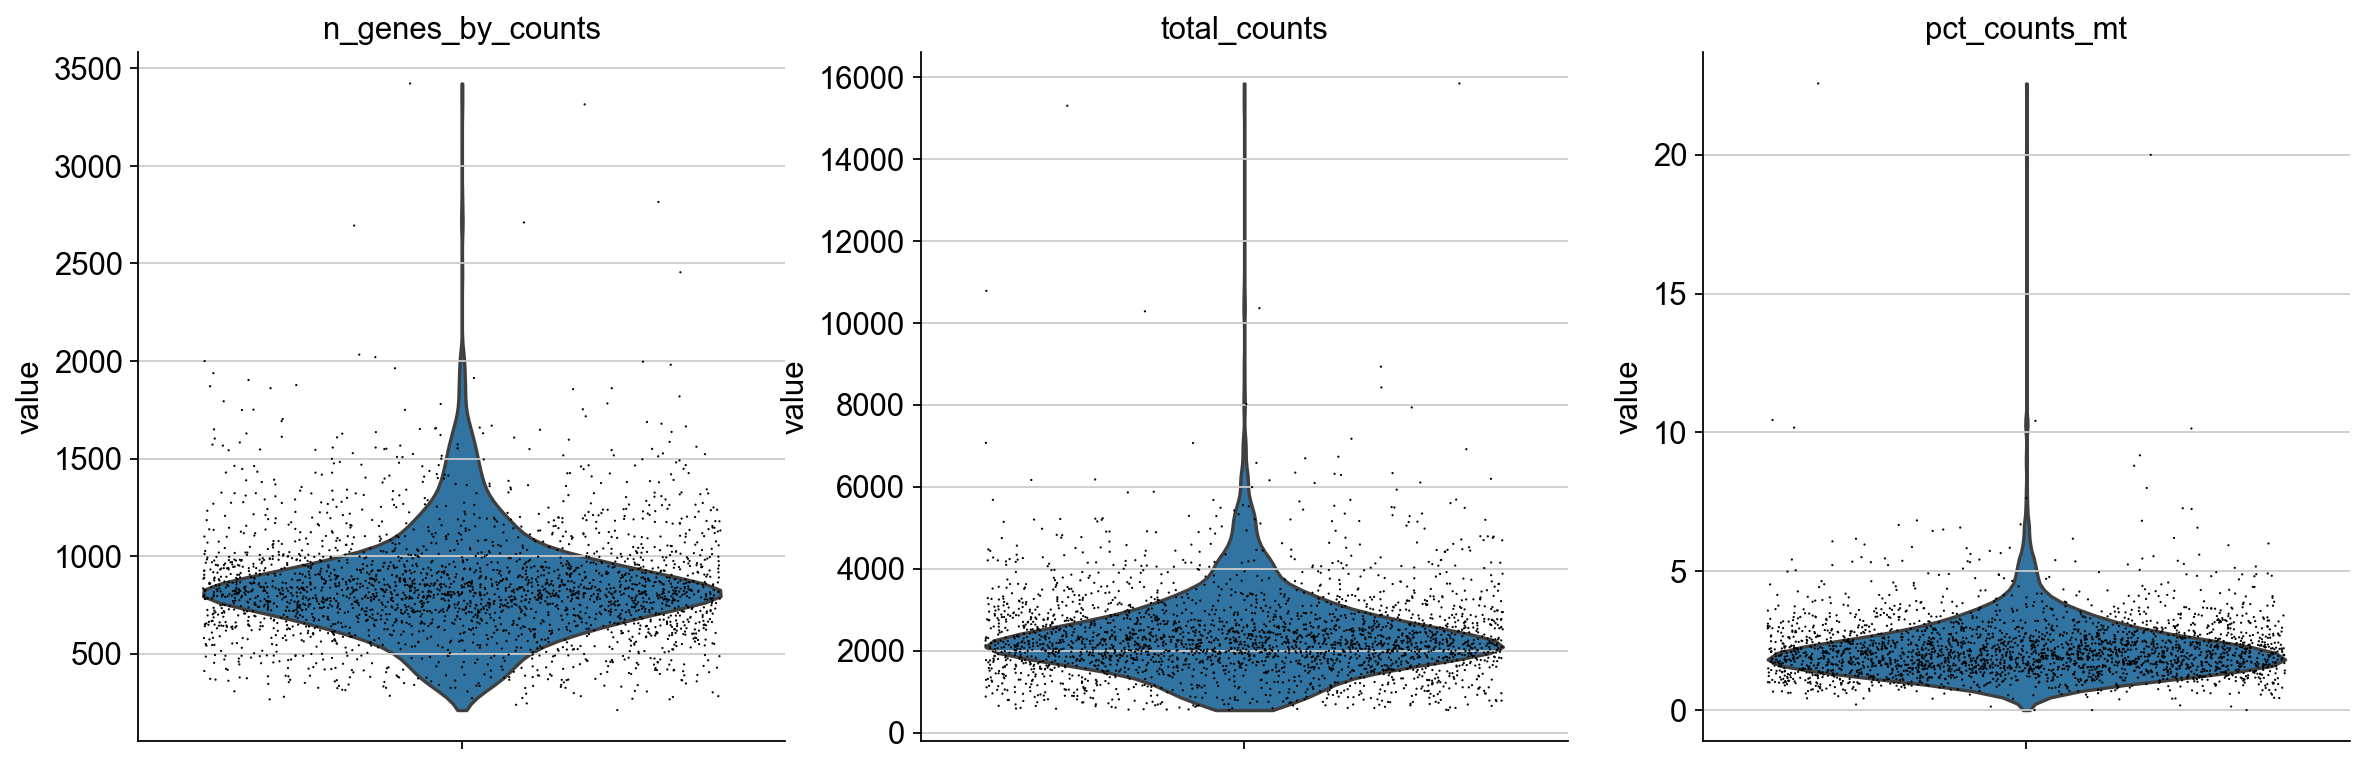

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

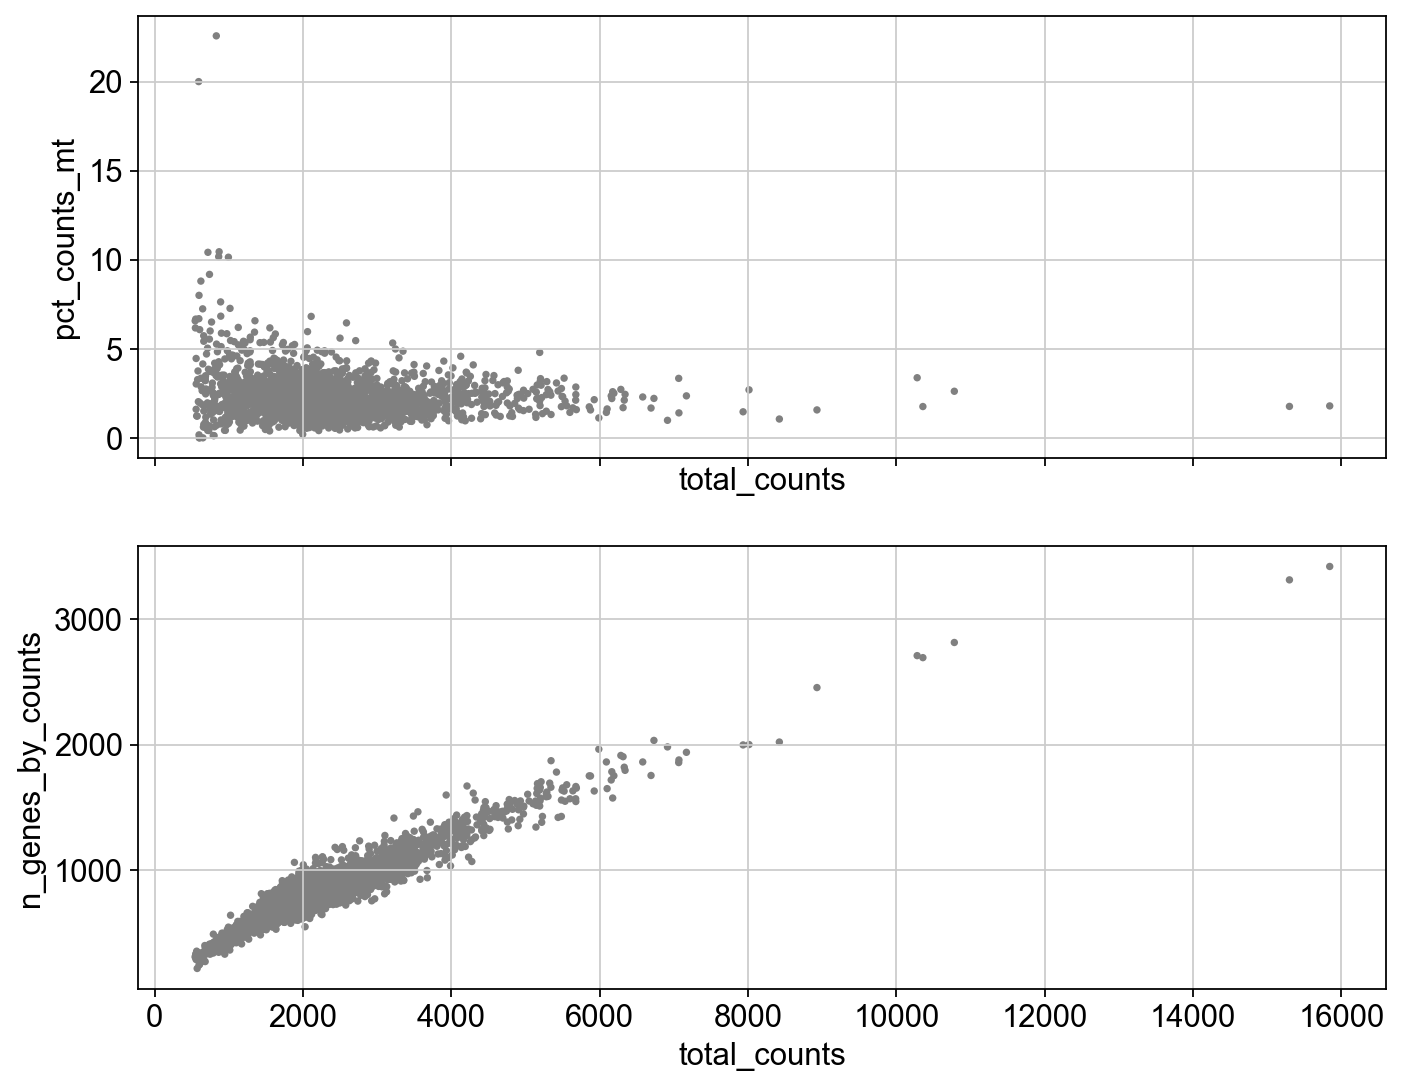

In [21]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axes[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axes[1])

I prefer to take a look at the QC thresholds on the plot

In [35]:
MAX_COUNTS_THRESHOLD = 2500
MAX_MITO_THRESHOLD = 5

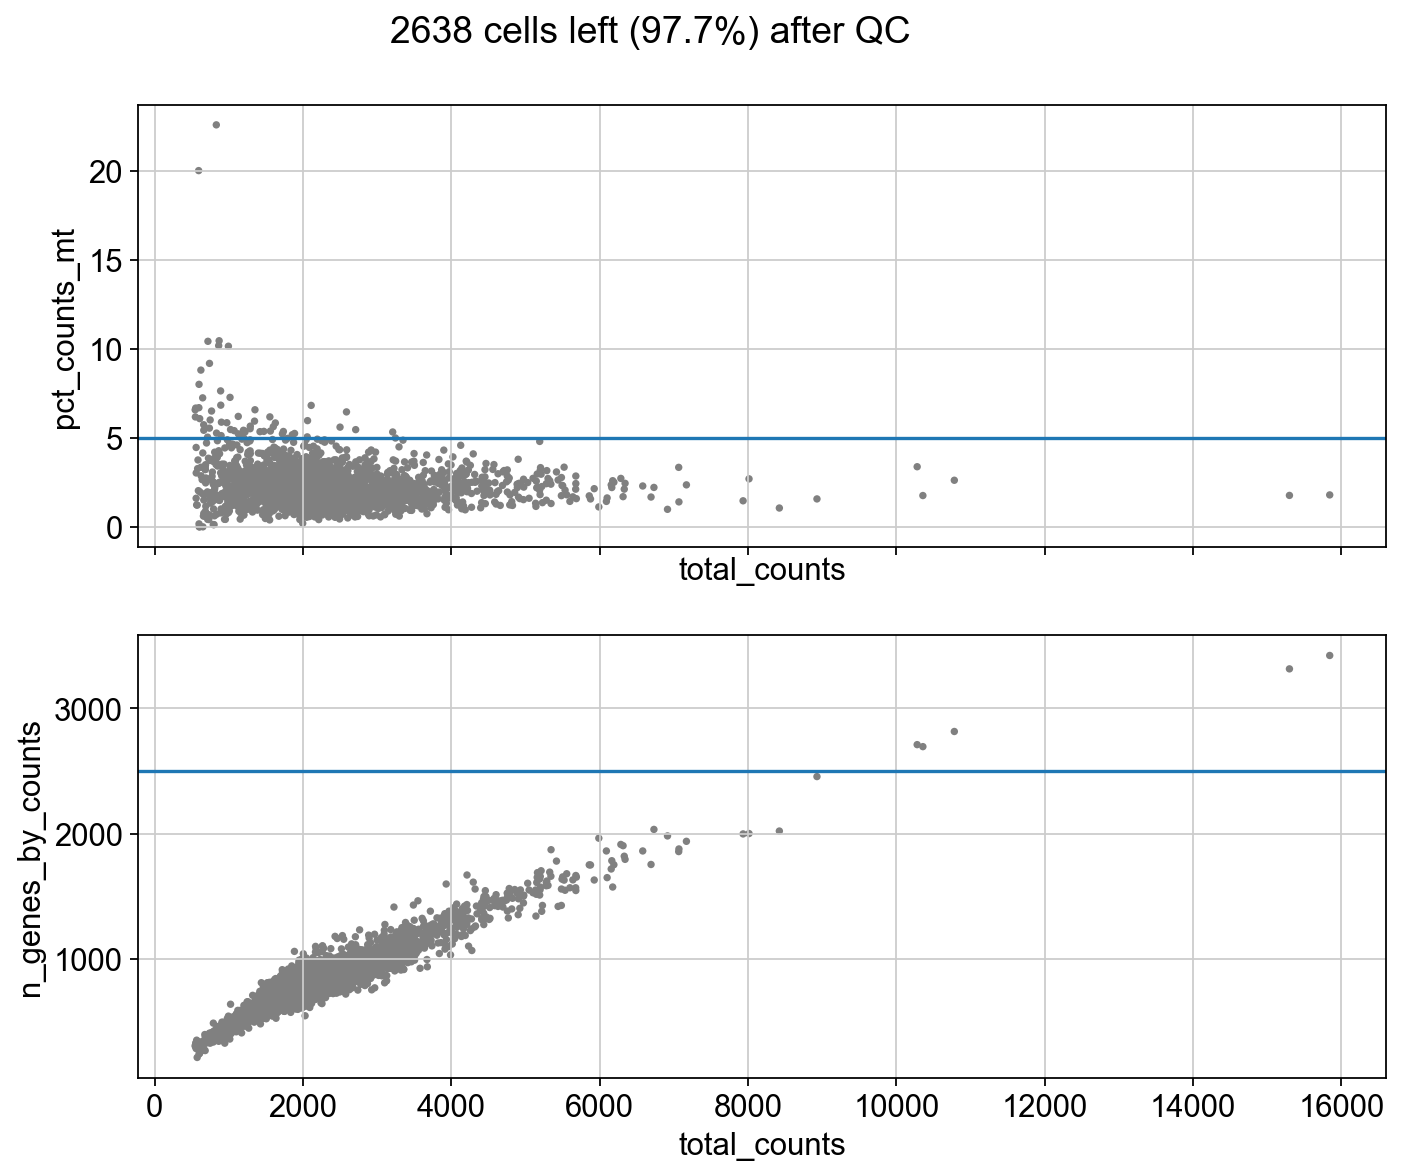

In [36]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axes[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axes[1], show=False)

axes[0].axhline(MAX_MITO_THRESHOLD)
axes[1].axhline(MIN_COUNTS_THRESHOLD)

n_cells_left = adata[
    (adata.obs.n_genes_by_counts < MAX_COUNTS_THRESHOLD) & (adata.obs.pct_counts_mt < MAX_MITO_THRESHOLD), :
].n_obs
cells_left_percent = round(n_cells_left / adata.n_obs, 4) * 100

fig.suptitle(f"{n_cells_left} cells left ({cells_left_percent}%) after QC");

Looks good. Let's perform filtering

In [38]:
adata = adata[adata.obs.n_genes_by_counts < MAX_COUNTS_THRESHOLD, :]
adata = adata[adata.obs.pct_counts_mt < MAX_MITO_THRESHOLD, :]

# Data preprocessing

Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

In [39]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/vladimirshitov/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data:

In [44]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [45]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


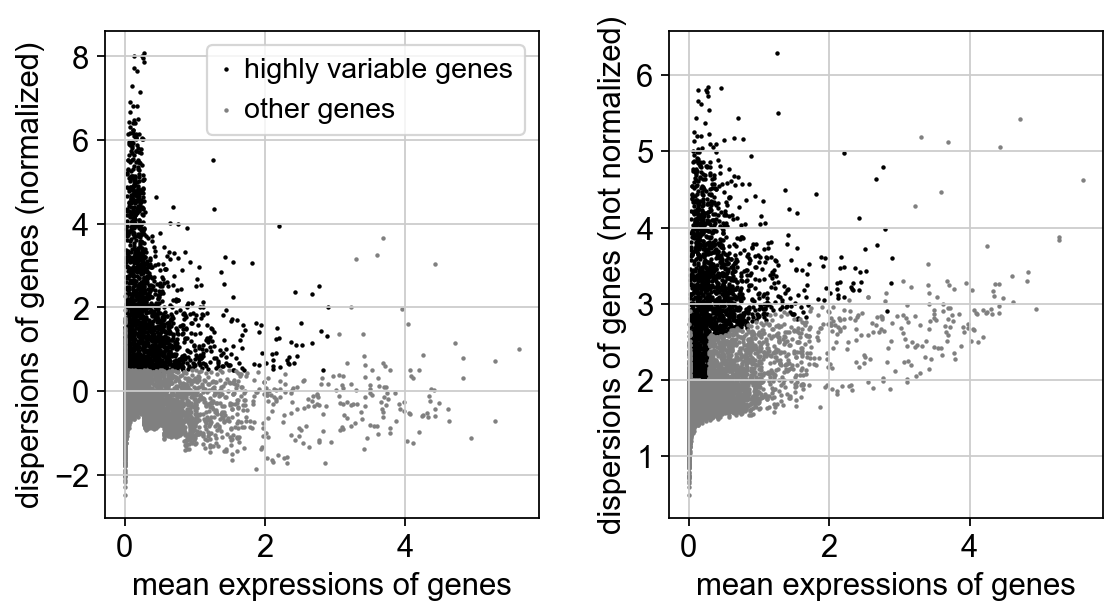

In [46]:
sc.pl.highly_variable_genes(adata)

Freeze the state of the AnnData object.

In [47]:
adata.raw = adata

Actually do the filtering

In [48]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [49]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:11)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [50]:
sc.pp.scale(adata, max_value=10)

# Principal component analysis

In [51]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


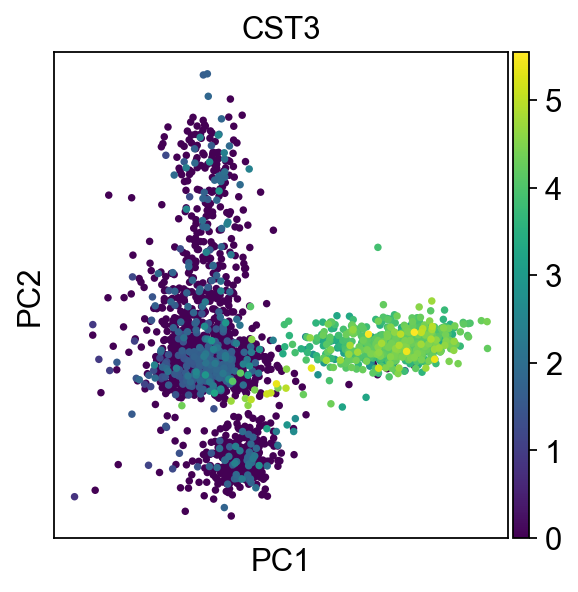

In [52]:
sc.pl.pca(adata, color='CST3')

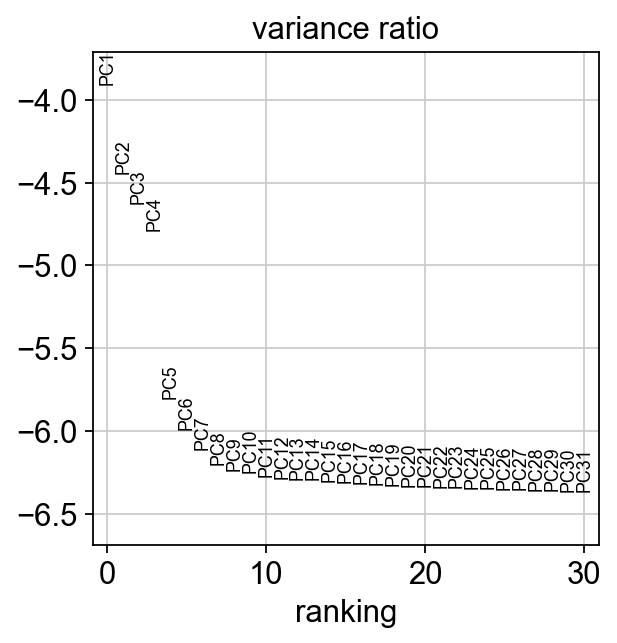

In [57]:
sc.pl.pca_variance_ratio(adata, log=True)

Save results

In [63]:
adata.write(RESULTS_FILE)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Computing the neighborhood graph

In [64]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding the neighborhood graph

In [65]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


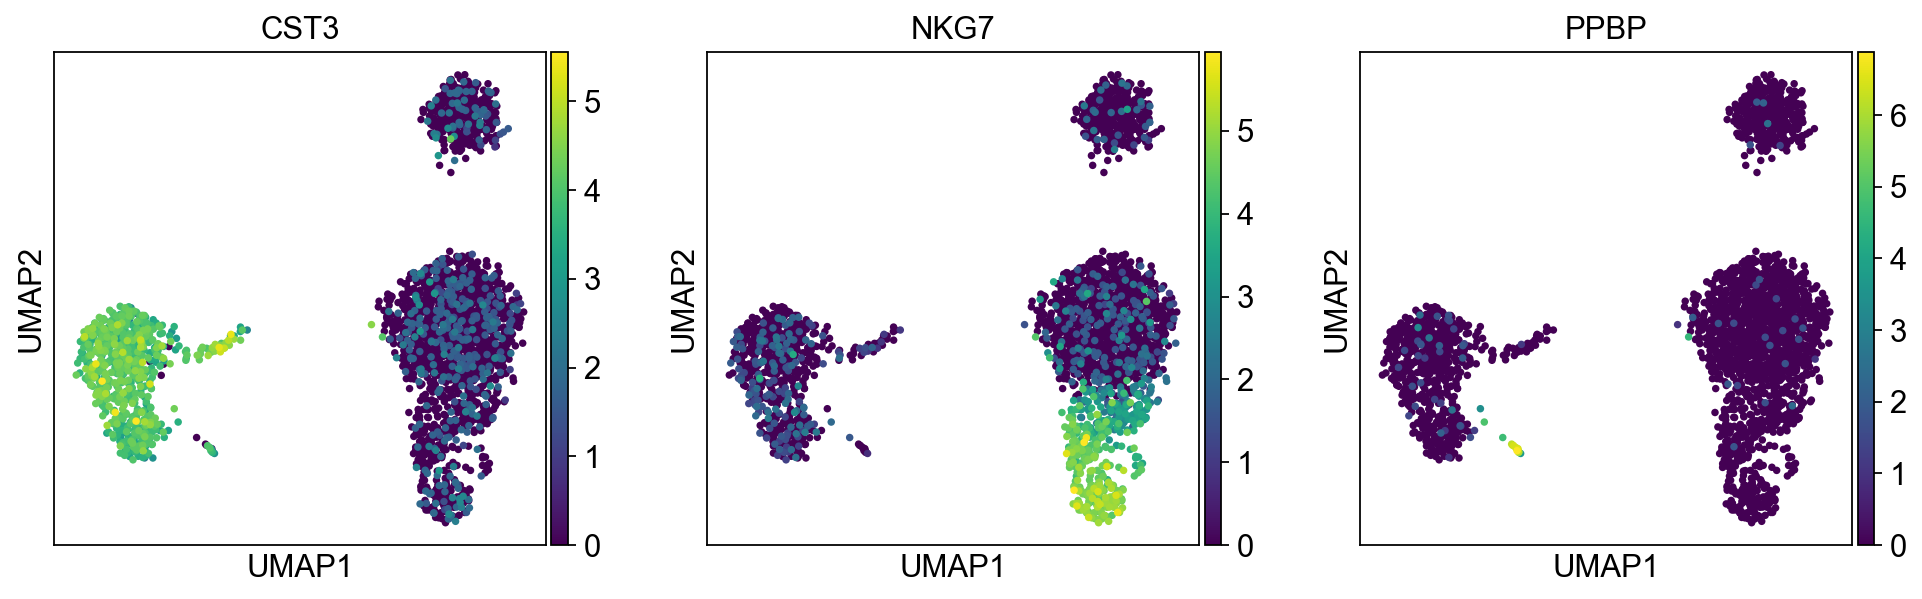

In [67]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])  # Shows logarithm of raw expresion, not corrected

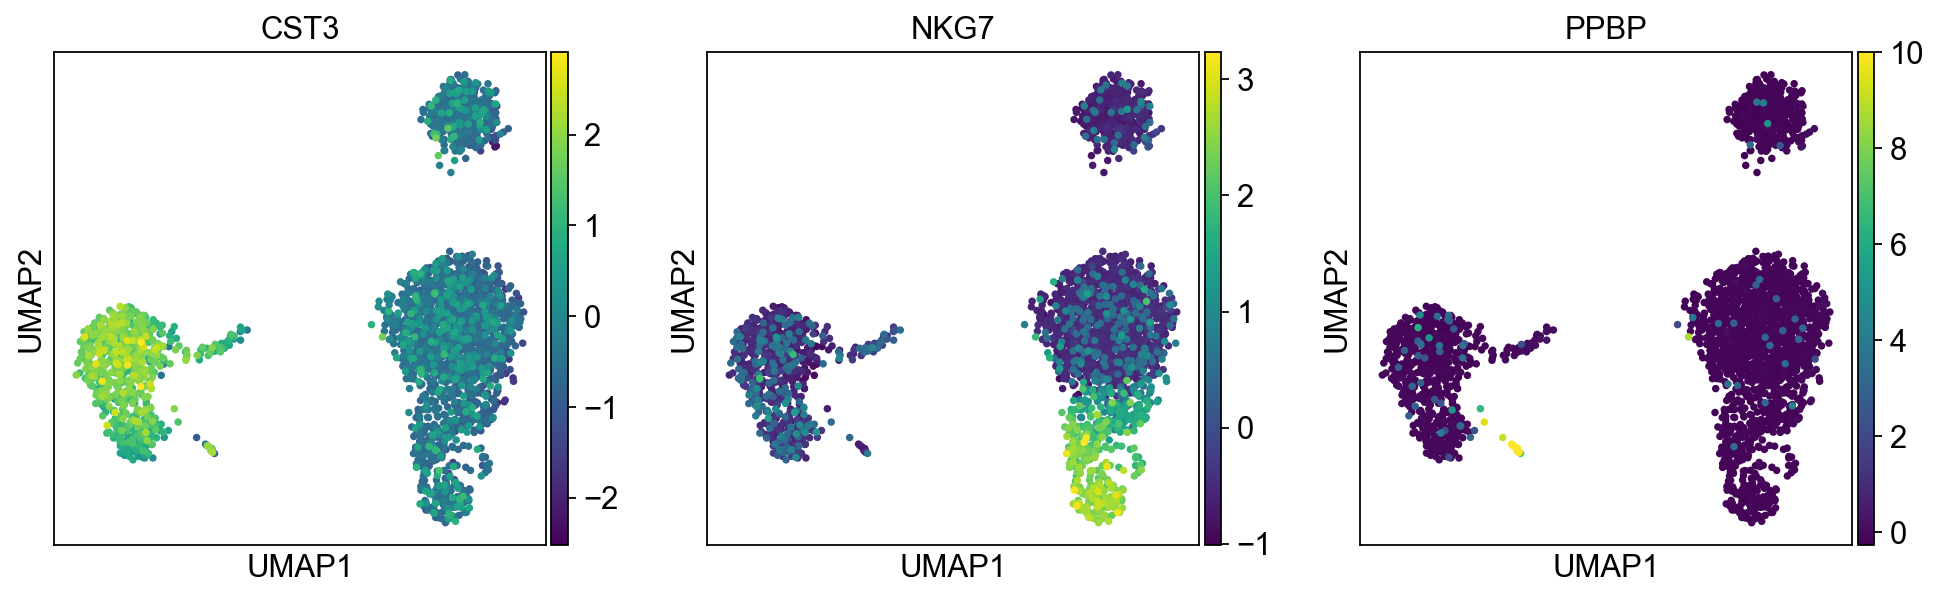

In [68]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)  # Corrected expression values

# Clustering the neighborhood graph

In [69]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


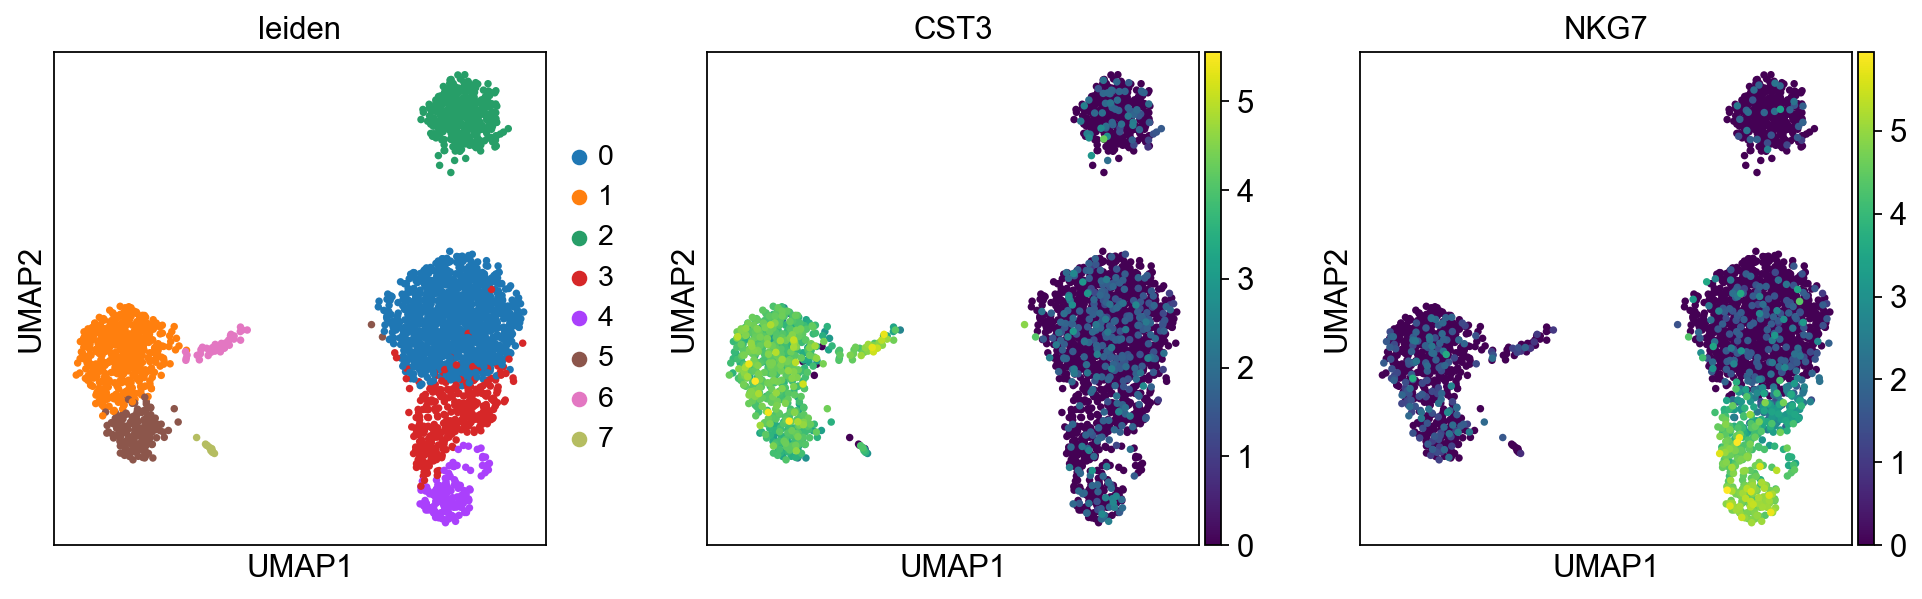

In [70]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [72]:
adata.write(RESULTS_FILE)

# Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


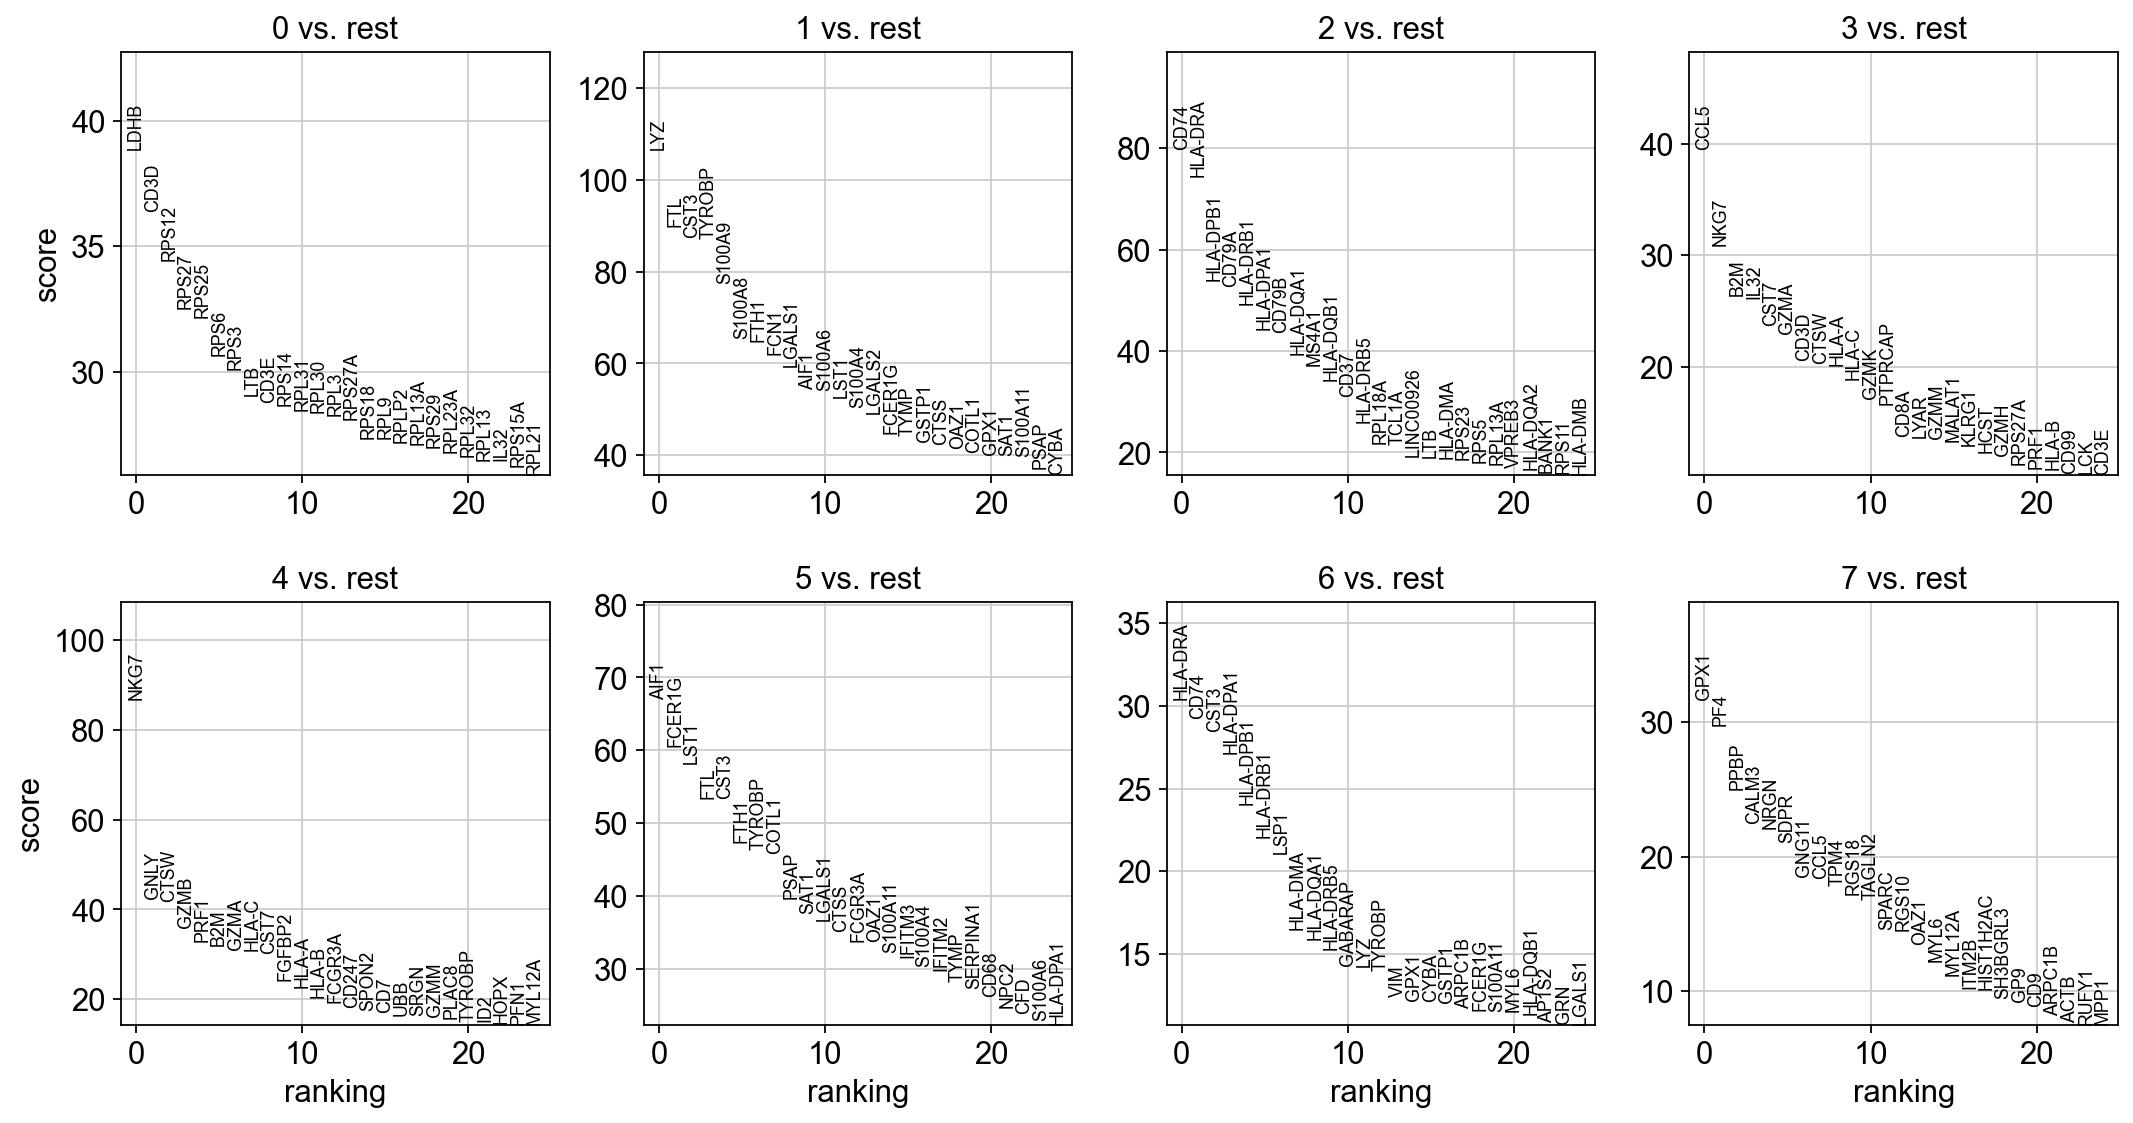

In [73]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Use other statistical test to find marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


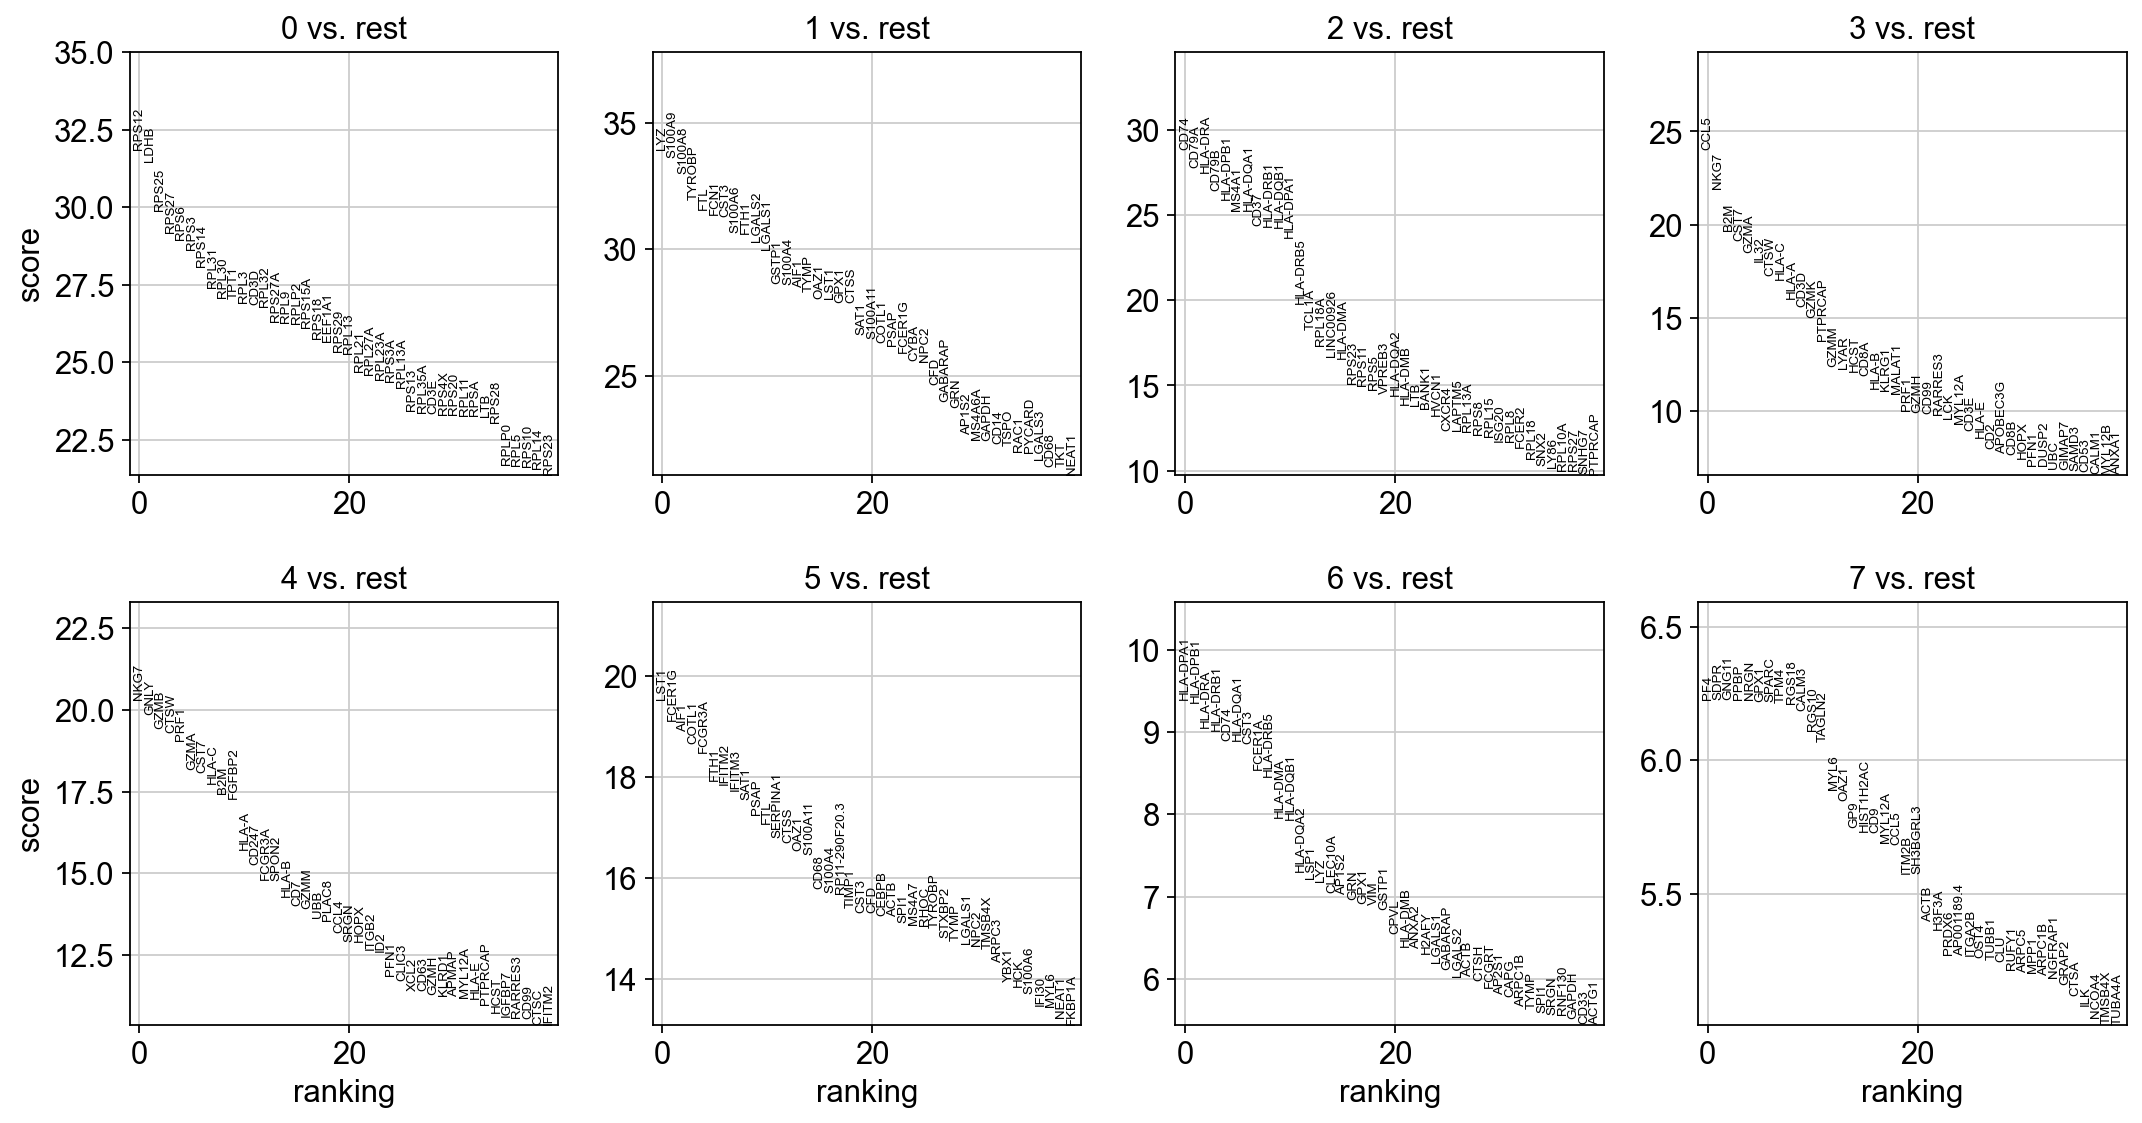

In [82]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=40, sharey=False, fontsize=6)

In [75]:
adata.write(RESULTS_FILE)

Use marker genes from the tutorial

|Louvain Group|	Markers	|Cell Type
|-|-|-|
0|	IL7R|	CD4 T cells
1|	CD14, LYZ|	CD14+ Monocytes
2|	MS4A1|	B cells
3|	CD8A|	CD8 T cells
4|	GNLY, NKG7|	NK cells
5|	FCGR3A, MS4A7|	FCGR3A+ Monocytes
6|	FCER1A, CST3|	Dendritic Cells
7|	PPBP|	Megakaryocytes


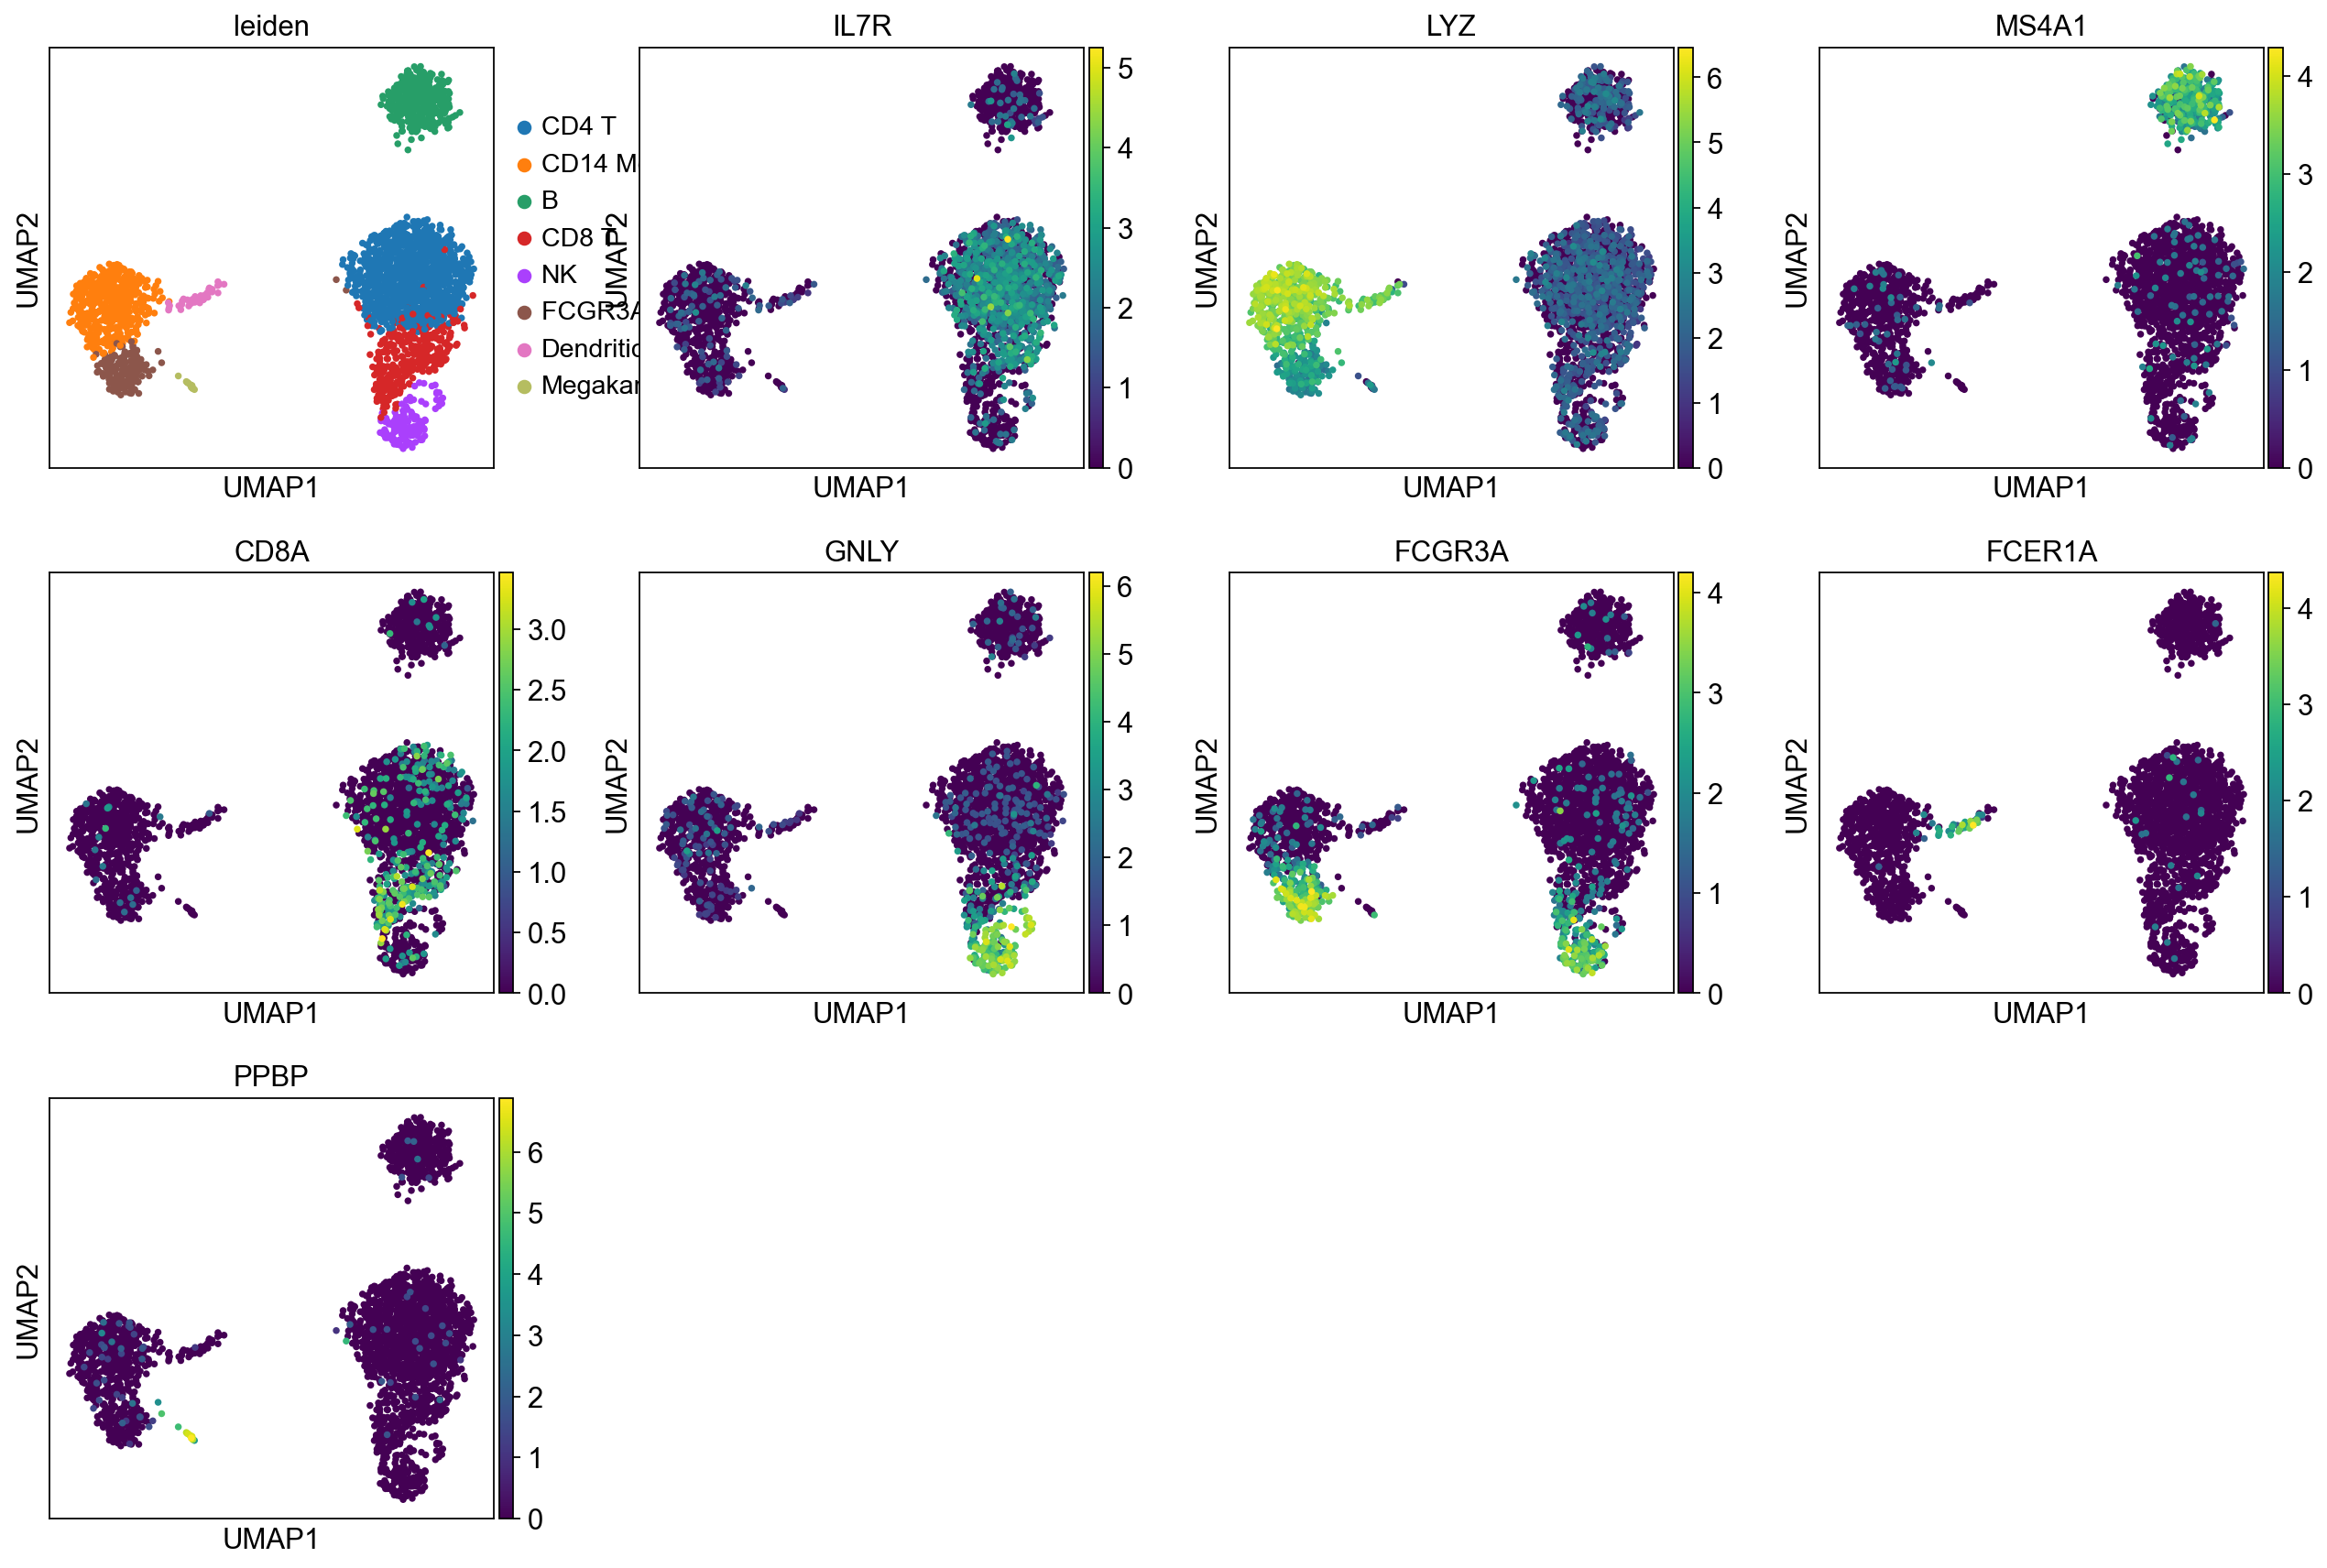

In [109]:
MARKER_GENES = [
    'IL7R',
    'LYZ',
    'MS4A1',
    'CD8A',
    'GNLY',
    'FCGR3A',
    'FCER1A',
    'PPBP'
]

sc.pl.umap(adata, color=['leiden'] + MARKER_GENES)

Show the top ranked genes per cluster in a dataframe.

In [90]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head()

0       1         2     3     4       5         6      7
0  RPS12     LYZ      CD74  CCL5  NKG7    LST1  HLA-DPA1    PF4
1   LDHB  S100A9     CD79A  NKG7  GNLY  FCER1G  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M  GZMB    AIF1   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7  CTSW   COTL1  HLA-DRB1   PPBP
4   RPS6     FTL  HLA-DPB1  GZMA  PRF1  FCGR3A      CD74   NRGN

Get a table with the scores and groups.

In [91]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  9.015588e-223     LYZ  1.007060e-252      CD74  2.487145e-183  CCL5   
1   LDHB  1.626290e-217  S100A9  3.664292e-248     CD79A  1.679730e-170  NKG7   
2  RPS25  1.951517e-196  S100A8  9.457377e-239   HLA-DRA  6.949695e-167   B2M   
3  RPS27  4.752164e-187  TYROBP  2.209430e-224     CD79B  2.569135e-154  CST7   
4   RPS6  3.395087e-184     FTL  3.910903e-219  HLA-DPB1  3.580735e-148  GZMA   

             3_p   4_n           4_p     5_n           5_p       6_n  \
0  1.097996e-127  NKG7  7.177518e-92    LST1  5.650219e-85  HLA-DPA1   
1  1.563796e-106  GNLY  7.658517e-88  FCER1G  1.697236e-81  HLA-DPB1   
2   1.927245e-86  GZMB  5.228287e-84    AIF1  1.377723e-79   HLA-DRA   
3   1.367014e-81  CTSW  3.435934e-83   COTL1  9.684016e-78  HLA-DRB1   
4   2.091531e-76  PRF1  3.960875e-81  FCGR3A  2.516161e-76      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

Compare to a single cluster:

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


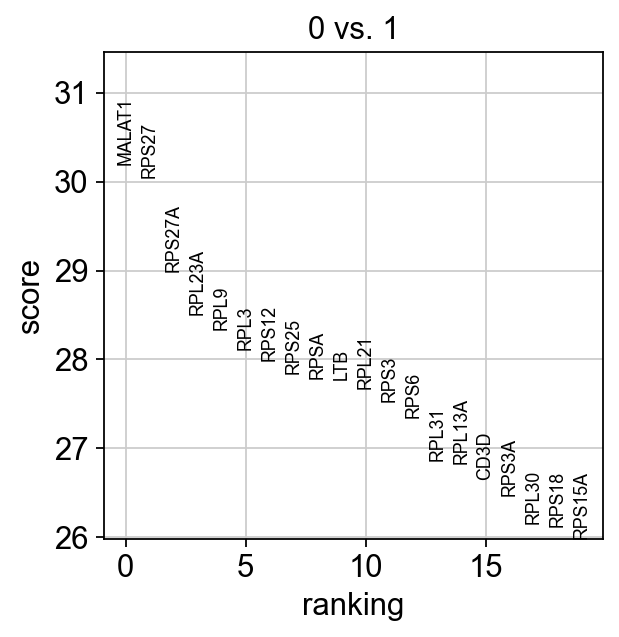

In [92]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

More detailed view of the differences on a violin plot

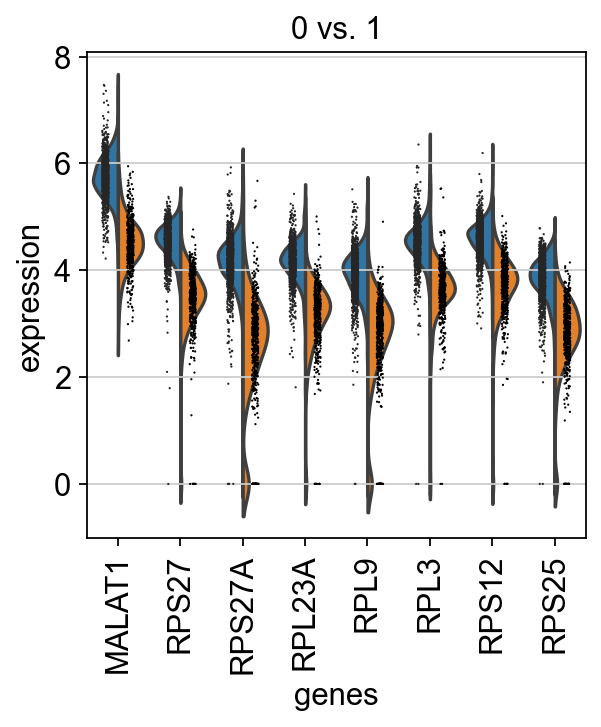

In [93]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [95]:
adata = sc.read(RESULTS_FILE)

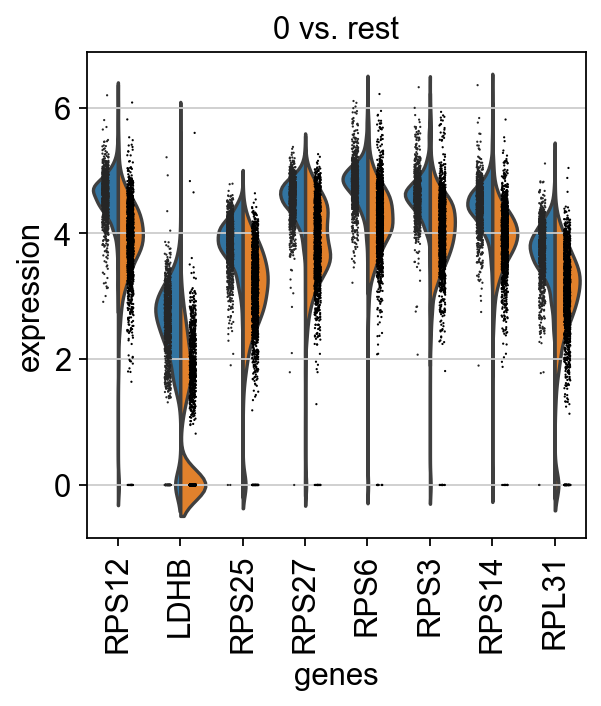

In [96]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Comparison of a certain gene across groups:

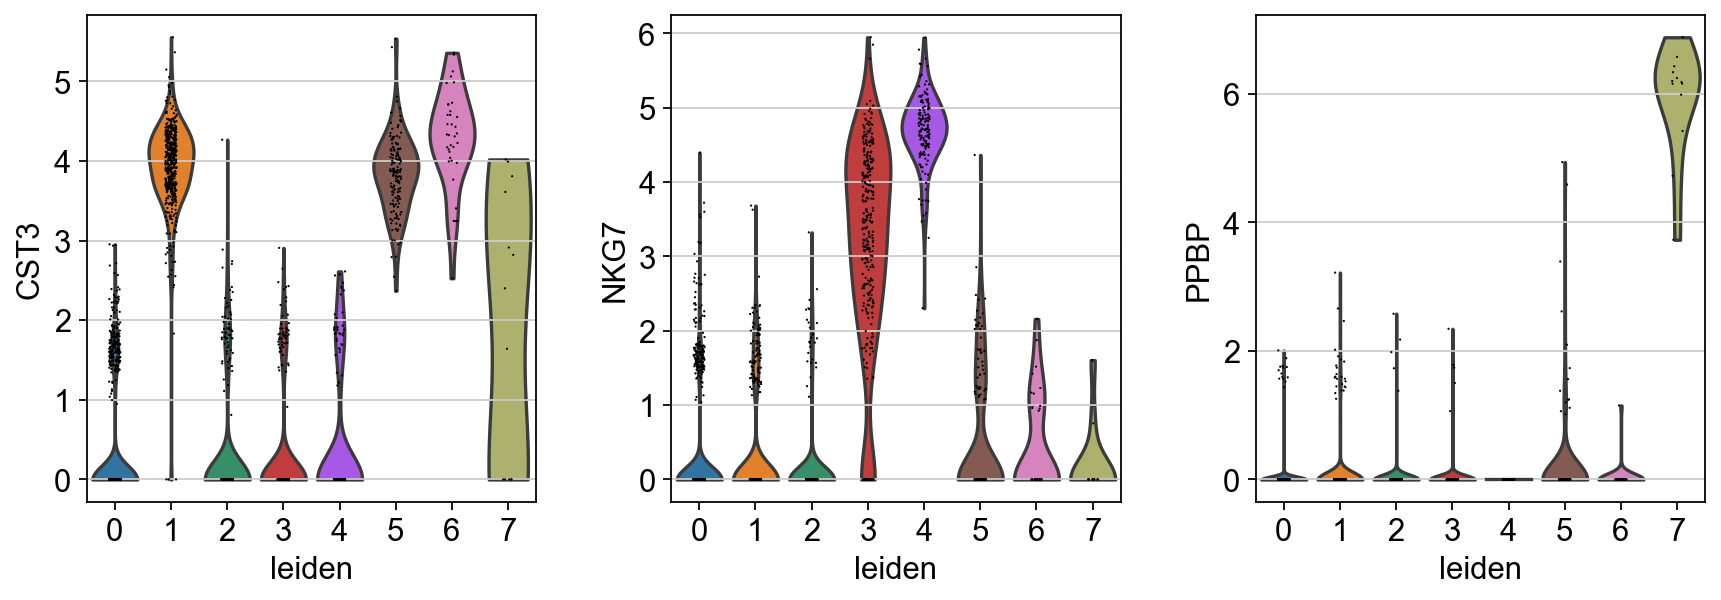

In [97]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [98]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/Users/vladimirshitov/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1163: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


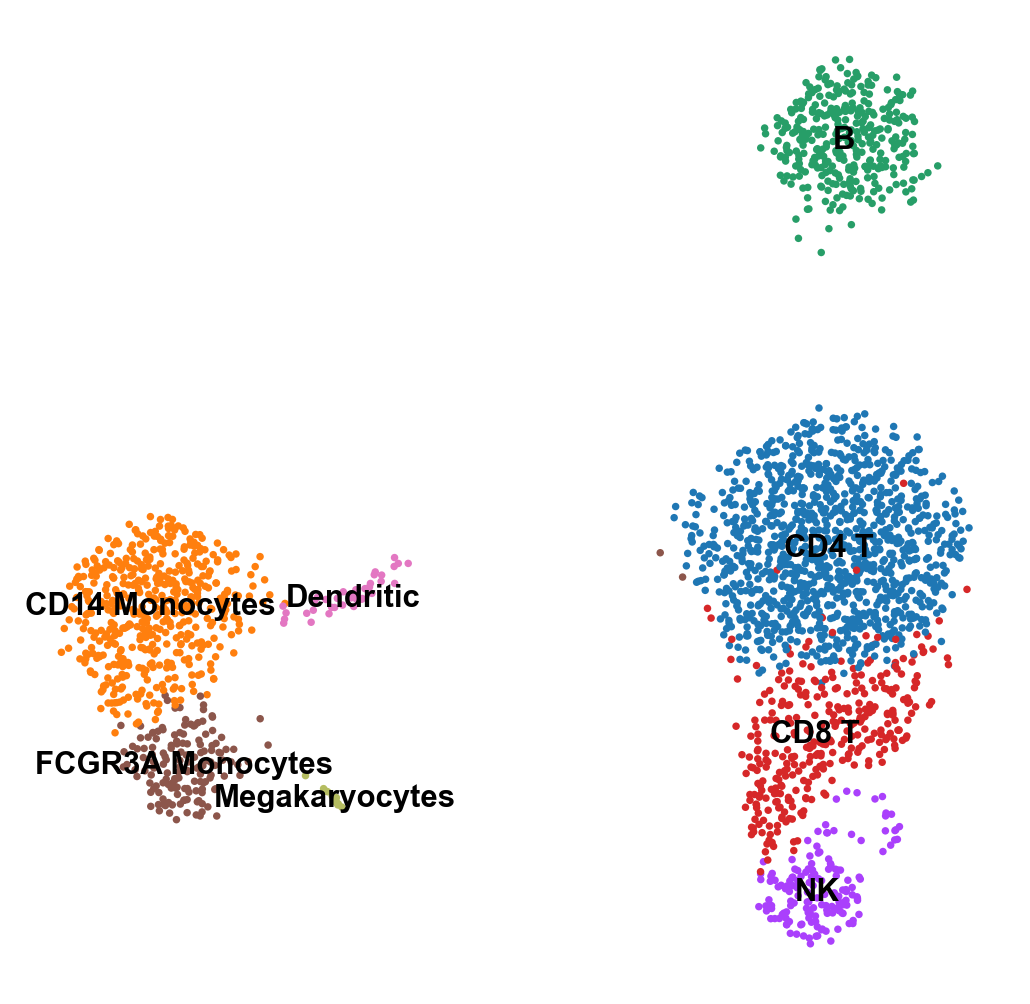

In [105]:
with plt.rc_context({"figure.figsize": (8, 8)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

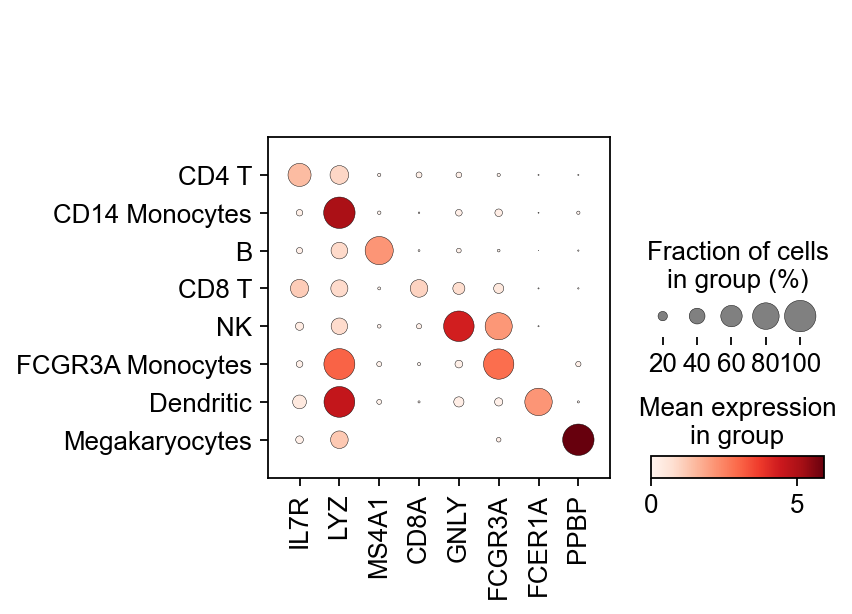

In [107]:
sc.pl.dotplot(adata, MARKER_GENES, groupby='leiden');

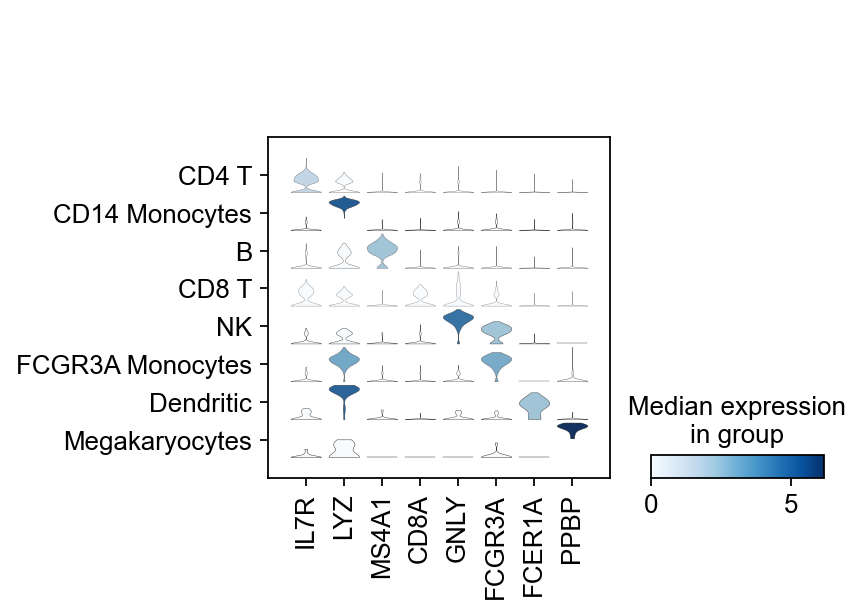

In [111]:
sc.pl.stacked_violin(adata, MARKER_GENES, groupby='leiden', rotation=90);

In [112]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [114]:
adata.write(RESULTS_FILE, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading